In [280]:
import requests
import numpy as np
import pandas as pd 
import time
import pickle
import multiprocessing
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
# Set up the API call variables
year = '2021'
season_type = '02'
max_game_ID = 2000 + 1

def get_game(i):
    game_ID = year + season_type +str(i).zfill(4)
    try:
        r = requests.get(url='http://statsapi.web.nhl.com/api/v1/game/'+ game_ID +'/feed/live',
                         timeout=5)
        data = r.json()
        return data
    except:
        pass

print("Getting Started with Data Collection")

start = time.time()

with multiprocessing.Pool(20) as pool:
        results = pool.map(get_game, range(1,max_game_ID))

end = time.time()

print("For", max_game_ID, "samples, it took", (end - start))

print("The Max Games to capture was:", max_game_ID, ". And we got these many results:", results.__len__())

file_name = "data_" + str(max_game_ID)
with open(file_name, "wb") as fp:
    pickle.dump(results, fp)
    print("Done writing results to", file_name)


In [2]:
# Stored it locally for ease of use
with open("./data_2001.pkl", "rb") as f:
    game_data = pickle.load(f)

In [170]:
# event, x, y, team_o (offence team), team_d (defending team), period, player_o, year, month

event_types = ['Shot','Goal']

master_data = []

for data in game_data:
    if 'liveData' not in data or 'gameData' not in data:
        continue
    
    teams = {
        "away": data['gameData']['teams']['away']['name'],
        "home": data['gameData']['teams']['home']['name']
    }
    teams_list = list(teams.values())
    plays = data['liveData']['plays']['allPlays']
    
    # Year and month of game
    date = data['gameData']['datetime']['dateTime'].split('-')
    year = date[0]
    month = date[1]
    
    for play in plays:
        for event in event_types:
            
            if play['result']['event'] in [event]:
                if 'x' in play['coordinates'] and 'y' in play['coordinates']:
                    x = play['coordinates']['x']
                    y = play['coordinates']['y']
                else: 
                    print('No coordinates')
                    continue
                
                TEAM = play['team']['name']
                if TEAM:
                    team_o = TEAM
                    team_d = teams_list[(teams_list.index(TEAM) + 1) % 2]
                else: 
                    print('No team name')
                    continue
                
                # period
                period = play['about']['period']
                
                # To get the players
                description = play['result']['description']
                if description:
                    player_o = ' '.join(description.strip().split()[:2])
                else: 
                    print('No description')
                    continue
                
                # Get time stamp
                time_in_period = play["about"]["periodTime"]
                date_time = datetime.strptime(play["about"]["dateTime"], "%Y-%m-%dT%H:%M:%SZ").timestamp()
                
                master_data.append([event, x, y, team_o, team_d, period, player_o, year, month, time_in_period, date_time])

In [171]:
df = pd.DataFrame(master_data, columns=['event', 'x', 'y', 'team_o', 'team_d', 'period', 'player_o', 'year', 'month', 'time', 'datetime'])

In [275]:
df

,event,x,y,team_o,team_d,period,player_o,year,month,time,datetime
0,Shot,61.0,-32.0,Tampa Bay Lightning,Pittsburgh Penguins,1,Steven Stamkos,2021,10,01:03,1.634097e+09
1,Shot,-65.0,19.0,Pittsburgh Penguins,Tampa Bay Lightning,1,Brock McGinn,2021,10,01:44,1.634097e+09
2,Shot,-8.0,-27.0,Tampa Bay Lightning,Pittsburgh Penguins,1,Jan Rutta,2021,10,02:01,1.634097e+09
3,Shot,-60.0,-4.0,Pittsburgh Penguins,Tampa Bay Lightning,1,Danton Heinen,2021,10,02:47,1.634097e+09
4,Shot,63.0,4.0,Tampa Bay Lightning,Pittsburgh Penguins,1,Ondrej Palat,2021,10,03:07,1.634097e+09
...,...,...,...,...,...,...,...,...,...,...,...
83607,Shot,50.0,41.0,Seattle Kraken,San Jose Sharks,3,Ryan Donato,2022,04,13:34,1.651306e+09
83608,Shot,-39.0,34.0,San Jose Sharks,Seattle Kraken,3,Marc-Edouard Vlasic,2022,04,16:13,1.651307e+09
83609,Shot,-30.0,31.0,San Jose Sharks,Seattle Kraken,3,Brent Burns,2022,04,16:43,1.651307e+09
83610,Shot,-57.0,-18.0,San Jose Sharks,Seattle Kraken,3,Thomas Bordeleau,2022,04,18:25,1.651307e+09


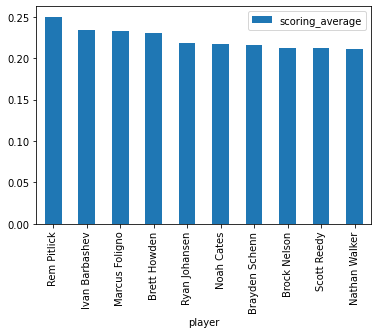

In [277]:
players = df["player_o"].unique()

player_scoring_data = []

for player in players:
    player_df = df[df["player_o"] == player]
    if len(player_df) < 20:
        continue
    events = player_df["event"]
    events = events.apply(lambda x: 1 if x == "Goal" else 0)
    player_scoring_data.append([player, events.mean()])

df_player_score = pd.DataFrame(player_scoring_data, columns=["player", "scoring_average"])

sorted_df_player_score = df_player_score.sort_values(by="scoring_average", ascending=False)

sorted_df_player_score.iloc[:10].plot.bar(x="player", y="scoring_average")
plt.show()



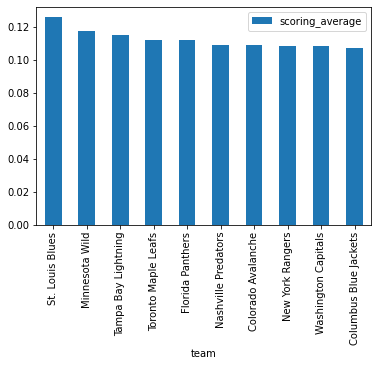

In [278]:
teams_o = df["team_o"].unique()

team_o_scoring_data = []

for team in teams_o:
    team_df = df[df["team_o"] == team]
    if len(team_df) < 20:
        continue
    events = team_df["event"]
    events = events.apply(lambda x: 1 if x == "Goal" else 0)
    team_o_scoring_data.append([team, events.mean()])
    
df_team_score = pd.DataFrame(team_o_scoring_data, columns=["team", "scoring_average"])

sorted_df_team_score = df_team_score.sort_values(by="scoring_average", ascending=False)

sorted_df_team_score.iloc[:10].plot.bar(x="team", y="scoring_average")
plt.show()



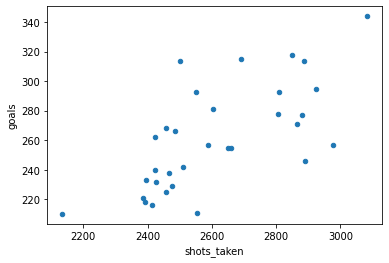

In [279]:
team_o_shots_goals_data = []

for team in teams_o:
    team_df = df[df["team_o"] == team]
    if len(team_df) < 20:
        continue
    events = team_df["event"]
    total_number_of_shots = len(events)
    total_number_of_goals = events.value_counts()["Goal"]
    team_o_shots_goals_data.append([team, total_number_of_shots, total_number_of_goals])
    
df_team_shots_goals = pd.DataFrame(team_o_shots_goals_data, columns=["team", "shots_taken", "goals"])

df_team_shots_goals.plot.scatter(x="shots_taken", y="goals")
plt.show()



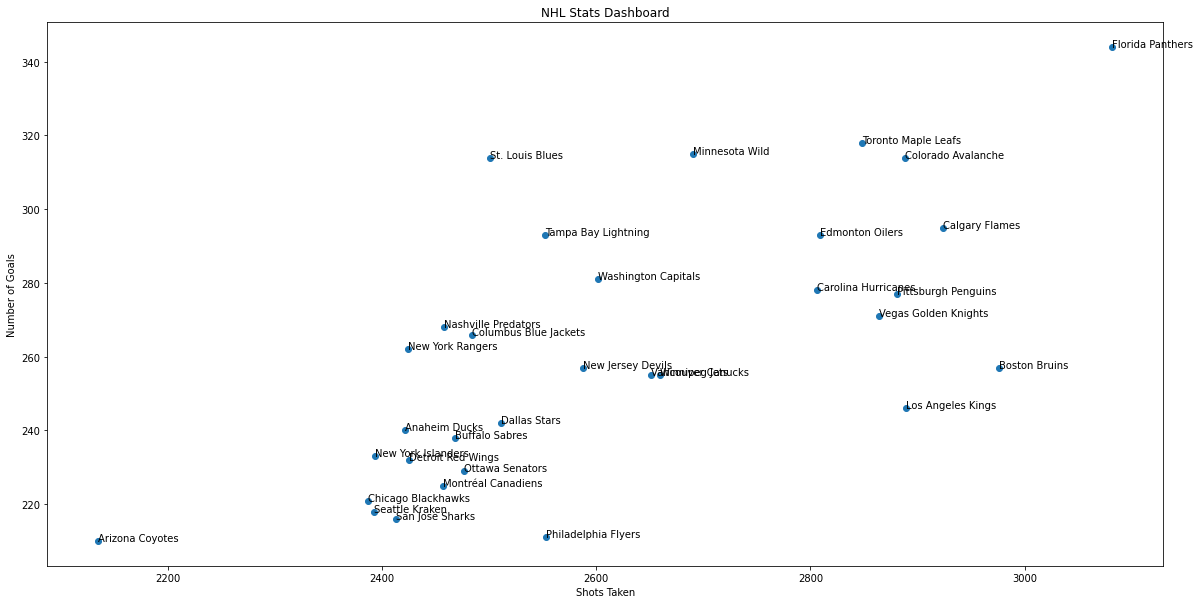

In [250]:
x = df_team_shots_goals["shots_taken"]
y = df_team_shots_goals["goals"]
labels = df_team_shots_goals["team"]

fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(x, y)

for i, label in enumerate(labels):
    ax.annotate(label, (x[i], y[i]))
    
plt.xlabel("Shots Taken")
plt.ylabel("Number of Goals")
plt.title("NHL Stats Dashboard")
plt.show()



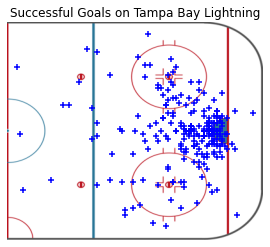

In [302]:
def y_coor_aug(df):
    mask_values = (df.x < 0).values.astype(np.int64)
    return np.where(mask_values == 0, 1, -1)

coors = df[ (df['team_d'] == 'Tampa Bay Lightning') & (df["event"] == "Goal") ][['x', 'y']]

y_mask = y_coor_aug(coors)
x = coors.x.abs()
y = coors.y * y_mask

image_file = "images/Hockey-field-half.png"
image = Image.open(image_file).resize((400,340))
image_arr = np.array(image.getdata())

image_arr = image_arr.reshape(image.size[1], image.size[0], 4)

plt.imshow(image_arr, extent=[0,100, -42.5, 42.5])
plt.scatter(x, y, marker="+", color="blue")

ax = plt.gca() #get current axes

#hide x-axis
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax.spines[["right", 'left', "top", "bottom"]].set_visible(False)

plt.title("Successful Goals on Tampa Bay Lightning")
plt.show()



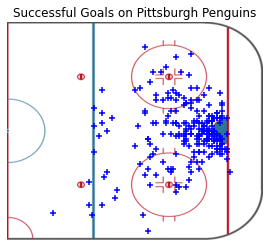

In [303]:
def y_coor_aug(df):
    mask_values = (df.x < 0).values.astype(np.int64)
    return np.where(mask_values == 0, 1, -1)

coors = df[ (df['team_d'] == 'Pittsburgh Penguins') & (df["event"] == "Goal") ][['x', 'y']]

y_mask = y_coor_aug(coors)
x = coors.x.abs()
y = coors.y * y_mask

image_file = "images/Hockey-field-half.png"
image = Image.open(image_file).resize((400,340))
image_arr = np.array(image.getdata())

image_arr = image_arr.reshape(image.size[1], image.size[0], 4)

plt.imshow(image_arr, extent=[0,100, -42.5, 42.5])
plt.scatter(x, y, marker="+", color="blue")

ax = plt.gca() #get current axes

#hide x-axis
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax.spines[["right", 'left', "top", "bottom"]].set_visible(False)

plt.title("Successful Goals on Pittsburgh Penguins")
plt.show()



In [257]:
df[ (df['team_o'] == 'Washington Capitals') & (df['player_o'] == "Alex Ovechkin")]

,event,x,y,team_o,team_d,period,player_o,year,month,time,datetime
216,Shot,52.0,31.0,Washington Capitals,New York Rangers,2,Alex Ovechkin,2021,10,18:10,1.634188e+09
222,Goal,-78.0,-13.0,Washington Capitals,New York Rangers,3,Alex Ovechkin,2021,10,02:37,1.634190e+09
233,Goal,-84.0,-3.0,Washington Capitals,New York Rangers,3,Alex Ovechkin,2021,10,12:01,1.634191e+09
1680,Shot,-55.0,-32.0,Washington Capitals,Tampa Bay Lightning,1,Alex Ovechkin,2021,10,05:00,1.634441e+09
1707,Shot,45.0,26.0,Washington Capitals,Tampa Bay Lightning,2,Alex Ovechkin,2021,10,14:19,1.634445e+09
...,...,...,...,...,...,...,...,...,...,...,...
80471,Shot,-59.0,-27.0,Washington Capitals,Toronto Maple Leafs,1,Alex Ovechkin,2022,04,15:09,1.650858e+09
80487,Shot,54.0,25.0,Washington Capitals,Toronto Maple Leafs,2,Alex Ovechkin,2022,04,18:08,1.650861e+09
80489,Shot,44.0,3.0,Washington Capitals,Toronto Maple Leafs,2,Alex Ovechkin,2022,04,19:54,1.650862e+09
82375,Shot,43.0,-27.0,Washington Capitals,Columbus Blue Jackets,2,Alex Ovechkin,2022,02,10:27,1.644388e+09


In [304]:
# Nikita Kucherov Alex Killorn Corey Perry


coors = df[ (df['team_o'] == 'Washington Capitals') & (df['player_o'] == "Alex Ovechkin") & (df["event"] == "Goal") ][['x', 'y']]

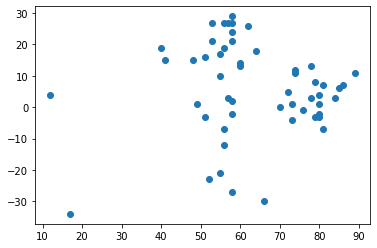

In [305]:
y_mask = y_coor_aug(coors)
x = coors.x.abs()
y = coors.y * y_mask


plt.scatter(x, y)
plt.show()

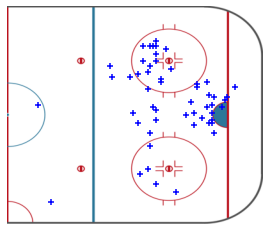

In [306]:
image_file = "images/Hockey-field-half.png"
image = Image.open(image_file).resize((400,340))
image_arr = np.array(image.getdata())

image_arr = image_arr.reshape(image.size[1], image.size[0], 4)

plt.imshow(image_arr, extent=[0,100, -42.5, 42.5])
plt.scatter(x, y, marker="+", color="blue")

ax = plt.gca() #get current axes

#hide x-axis
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax.spines[["right", 'left', "top", "bottom"]].set_visible(False)
# plt.show()